In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.io
import cmocean 
import sys
sys.path.insert(1, '/Users/emmagurcan/Documents/France/ENS/M1/stageM1/Codes')
import functions_MSM74 as f
import matplotlib.ticker as ticker
import netCDF4 as nc
import cartopy.crs as ccrs
from scipy.interpolate import griddata
import gsw


raw_ctd = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/raw_ctd.nc"
raw_ctd2 = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/raw_ctd2.nc"
nclonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_lonlat.nc"
readcp = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74-VMADCP_allfiles/msm_074_1_vmadcp_75khz_01.nc"
rep = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_CTD.tab"
lon_lat_event = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/lon_lat_event.nc"

ds_lonlat = nc.Dataset(nclonlat)
ds_adcp = nc.Dataset(readcp)
ds_ctd = nc.Dataset(raw_ctd)
lonlatev = nc.Dataset(lon_lat_event)

ctd_idx1, ctd_idx2, adcp_idx1, adcp_idx2 = f.section_MSM74(1)

lons_range = lonlatev['Longitude'][ctd_idx1:ctd_idx2]
lats_range = lonlatev['Latitude'][ctd_idx1:ctd_idx2]
events = np.array(lonlatev['Event'][ctd_idx1:ctd_idx2])

lats_ctd = ds_ctd['Latitude']
lons_ctd = ds_ctd['Longitude']
events_ctd = np.array(ds_ctd['Event'][:])
matching_indices = np.where(np.isin(events_ctd, events))[0]

# Extract data
times = np.array(ds_ctd['Time'][:])[matching_indices]
press = np.array(ds_ctd['Press [dbar]'][:])[matching_indices]
depth = np.array(ds_ctd['Depth water [m]'][:])[matching_indices]
T = np.array(ds_ctd['Temp [C]'])[matching_indices]
S = np.array(ds_ctd['Sal'])[matching_indices]
lon = np.array(lons_ctd[matching_indices])
lat = np.array(lats_ctd[matching_indices])

# Calculate distances
d1 = np.sin(lat*(math.pi/180))*np.sin(lat[0]*(math.pi/180))
d2 = np.cos(lat*(math.pi/180))*np.cos(lat[0]*(math.pi/180)) * \
    np.cos(abs(lon[0]-lon)*(math.pi/180))
distance = 6371*np.arccos(d1+d2)

# Convert practical salinity to absolute salinity
SA = gsw.SA_from_SP(S, press, lon, lat)  # Longitude and Latitude needed

# Convert in situ temperature to conservative temperature
CT = gsw.CT_from_t(SA, T, press)

# Calculate in situ density (kg/m³)
rho = gsw.rho(SA, CT, press)

# Calculate potential density anomaly referenced to 0 dbar
sigma0 = gsw.sigma0(SA, CT)  # Potential density anomaly (kg/m³ - 1000)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gsw/_wrapped_ufuncs.py:1143: RuntimeWarning: invalid value encountered in ct_from_t
  return _gsw_ufuncs.ct_from_t(SA, t, p)


In [2]:
distance.shape

(56187,)

In [3]:
depth.shape

(56187,)

In [4]:
mask = (T > -1)
T_filtered = T[mask]
distance_f = distance[mask]
depths_filtered = depth[mask]
sigma0_ = sigma0[mask]
grid_distance, grid_depth, filled_T = f.interpol(distance_f, depths_filtered, T_filtered)

(55013, 2)
(55013,)


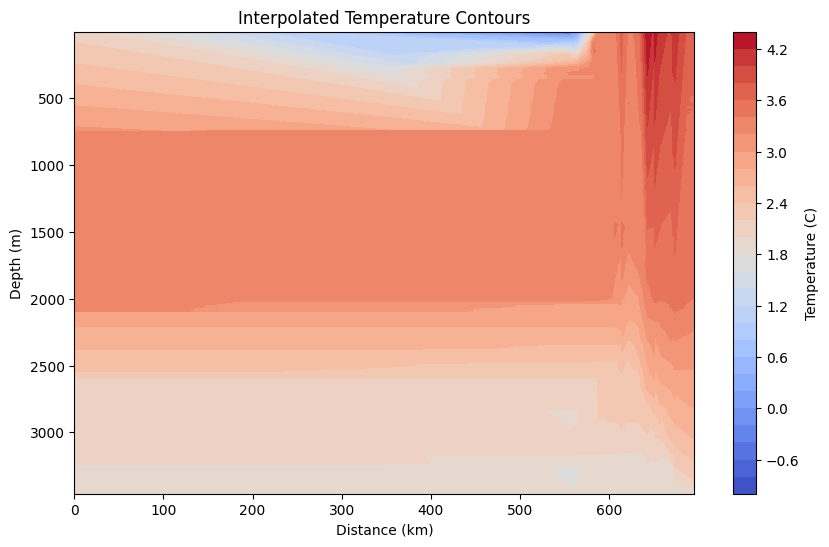

In [5]:
# --- Plot Contour ---
plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_distance, grid_depth, filled_T, levels=30, cmap="coolwarm")
cbar = plt.colorbar(contour)
cbar.set_label("Temperature (C)")

# Add contour lines
# plt.contour(grid_distance, grid_depth, filled_PD, levels=np.arange(np.nanmin(filled_PD), np.nanmax(filled_PD), 0.2), colors='k', linewidths=0.8)

# Labels and formatting
plt.xlabel("Distance (km)")
plt.ylabel("Depth (m)")
plt.title("Interpolated Temperature Contours")
plt.gca().invert_yaxis()  # Depth increases downward
plt.show()

In [6]:
grid_distance, grid_depth, filled_PD = f.interpol(distance, depth, sigma0)

(55047, 2)
(55047,)


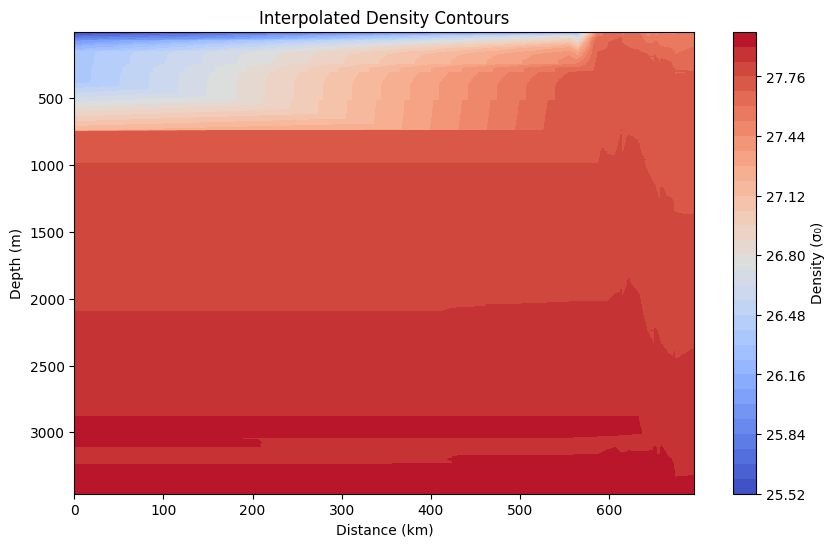

In [7]:
# --- Plot Contour ---
plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_distance, grid_depth, filled_PD, levels=30, cmap="coolwarm")
cbar = plt.colorbar(contour)
cbar.set_label("Density (σ₀)")

# Add contour lines
# plt.contour(grid_distance, grid_depth, filled_PD, levels=np.arange(np.nanmin(filled_PD), np.nanmax(filled_PD), 0.2), colors='k', linewidths=0.8)

# Labels and formatting
plt.xlabel("Distance (km)")
plt.ylabel("Depth (m)")
plt.title("Interpolated Density Contours")
plt.gca().invert_yaxis()  # Depth increases downward
plt.show()

In [8]:
mask = (S > 30) 
S_filtered = S[mask]
distance_f = distance[mask]
depths_filtered = depth[mask]
sigma0_ = sigma0[mask]
grid_distance, grid_depth, filled_S = f.interpol(distance_f, depths_filtered, S_filtered)

(55047, 2)
(55047,)


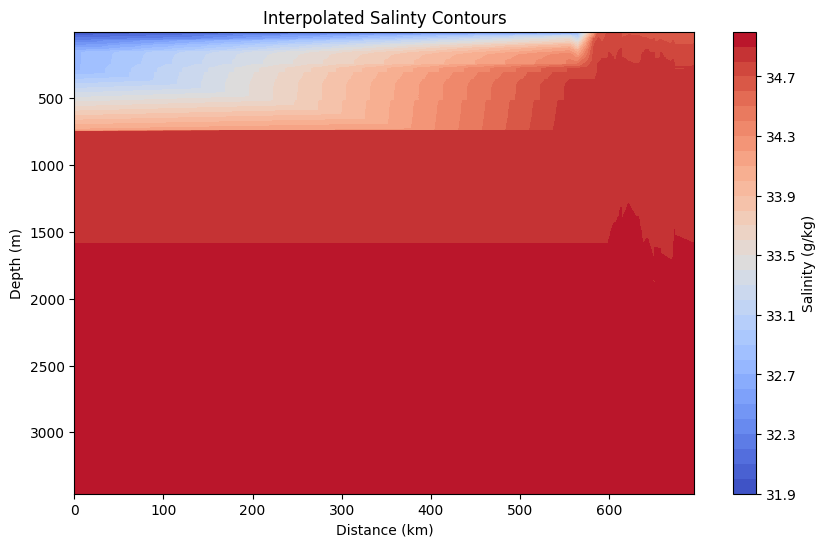

In [9]:
# --- Plot Contour ---
plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_distance, grid_depth, filled_S, levels=30, cmap="coolwarm")
cbar = plt.colorbar(contour)
cbar.set_label("Salinity (g/kg)")

# Add contour lines
# plt.contour(grid_distance, grid_depth, filled_PD, levels=np.arange(np.nanmin(filled_PD), np.nanmax(filled_PD), 0.2), colors='k', linewidths=0.8)

# Labels and formatting
plt.xlabel("Distance (km)")
plt.ylabel("Depth (m)")
plt.title("Interpolated Salinty Contours")
plt.gca().invert_yaxis()  # Depth increases downward
plt.show()